# MODEL BUILDING FOR PREDICT LOANS PAYMENT

### [1. Import Data](#1)
### [2. Data Exploration (EDA)](#2)
### [2.1. Visualize distribution](#2.1)
### [3. Feature Engineering & Single Factor Analysis (WOE transformation method)](#3)
### [4. Split dataset using stratify method](#4)
### [5. Correlation Test ](#5)
### [6. Modelling & Comparision ](#6)
 Logistic Regression, Xgboost, Decision Tree, Random Forest, KNN
### [7. Model evaluation ](#7)
### [7.1 ROC - AUC ](#7.1)
### [7.2 CAP Curve - GINI ](#7.2)
### [7.3 KS ](#7.3)
### [8. Understand the model ](#8)
 Coefficient, Feature Importance
### [9. Test oversample method/ other transformation method ](#9)
### [10. Scorecard ](#10)


<a id='# Import Package '></a>


## <font color=red>__1. Import Data __</font>
<a id='1'></a>



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
import pandas as pd

df = pd.read_excel(r'C:\Users\admin\Desktop\loans.xlsx',sheet_name='Data')


## <font color=red>__2. Data Exploration (EDA) __</font>
<a id='2'></a>



In [3]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


In [4]:
#missing value
missing_data = pd.DataFrame({"Missing value": df.isnull().sum()/ len(df.index)*100})
missing_data.reset_index()

,index,Missing value
0,credit.policy,0.000000
1,purpose,0.000000
2,int.rate,0.000000
3,installment,0.000000
4,log.annual.inc,0.041762
5,dti,0.000000
6,fico,0.000000
7,days.with.cr.line,0.302777
8,revol.bal,0.000000
9,revol.util,0.647317


In [5]:
def calculateAndPlotMissingData(data):
  total_data = len(data)
  total_miss = data.isnull().sum()
  percent_missing = total_miss*100/total_data
  missing_data = pd.concat(
      (total_miss,percent_missing),
      axis = 1,
      keys =['Missing value','Percentage missing value']).sort_values('Percentage missing value',ascending = True)
  missing_data = missing_data[missing_data['Percentage missing value'] != 0]
  plt.figure(figsize = (12,10))
  plt.barh(y = missing_data.index,
          width = missing_data['Percentage missing value'])
  plt.title('Percentage missing value')
  plt.ylabel('Column names')
  plt.xlabel('Percentage')
  return missing_data

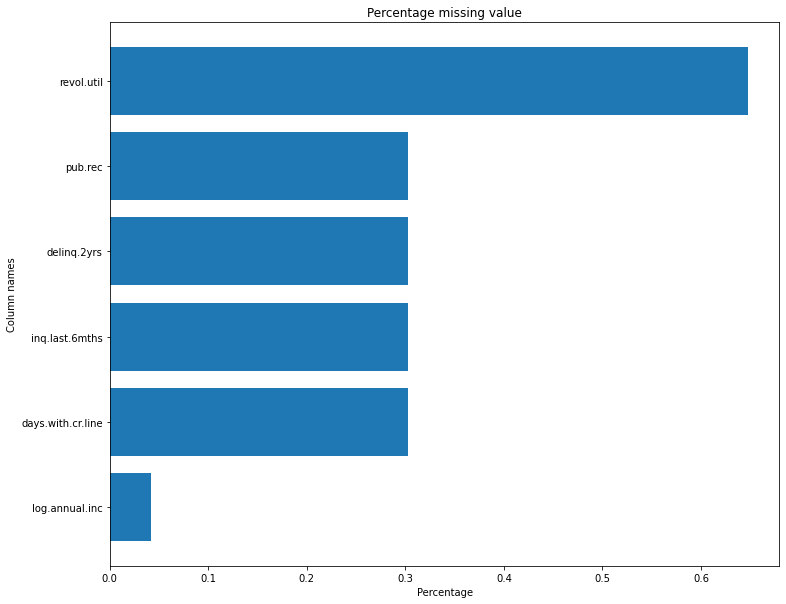

In [6]:
missing_data_train =  calculateAndPlotMissingData(df)

In [7]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9574.000000,9578.000000,9578.000000,9549.000000,9.578000e+03,9516.000000,9549.000000,9549.000000,9549.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.931874,12.606679,710.846314,4562.026085,1.691396e+04,46.865677,1.571578,0.163787,0.062101,0.160054
std,0.396245,0.026847,207.071301,0.614736,6.883970,37.970537,2497.985733,3.375619e+04,29.018642,2.198095,0.546712,0.262152,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.700000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.927987,12.665000,707.000000,4139.958333,8.596000e+03,46.400000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.289832,17.950000,737.000000,5730.000000,1.824950e+04,71.000000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9574 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9549 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9516 non-null   float64
 10  inq.last.6mths     9549 non-null   float64
 11  delinq.2yrs        9549 non-null   float64
 12  pub.rec            9549 non-null   float64
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 1.0+ MB


In [9]:
cat_cols = df.select_dtypes('object').columns
num_cols = df.select_dtypes(['int64','float64']).columns

In [10]:
print('total {} categories: {}'.format(len(cat_cols), cat_cols))
print('total {} numeric: {} '.format(len(num_cols), num_cols))

total 1 categories: Index(['purpose'], dtype='object')
total 13 numeric: Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object') 


In [11]:
df['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

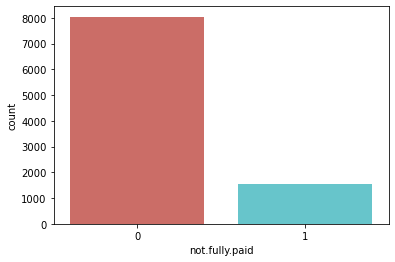

In [12]:
sns.countplot(x = 'not.fully.paid', data = df, palette ='hls')
plt.show()

In [13]:
count_not_fully_paid = len(df[df['not.fully.paid']==0])
count_fully_paid = len(df[df['not.fully.paid']==1])
pct_of_not_fully_paid = count_not_fully_paid/(count_fully_paid+count_not_fully_paid)
print("percentage of not fully paid is", pct_of_not_fully_paid*100)
pct_of_fully_paid = count_fully_paid/(count_fully_paid+count_not_fully_paid)
print("percentage of fully paid", pct_of_fully_paid*100)

percentage of not fully paid is 83.99457089162664
percentage of fully paid 16.005429108373356


Percentage of not fully paid is 84 %
percentage of fully paid is 16%
Our classes are imbalanced, and the ratio of not_fully_paid to fully paid instances is 84:16

In [14]:
df.groupby('purpose').mean()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
purpose,,,,,,,,,,,,,
all_other,0.787216,0.116771,244.937542,10.844164,11.079498,715.344058,4314.679096,12883.039897,39.891755,1.624837,0.180200,0.047764,0.166023
credit_card,0.808241,0.119738,319.500713,11.047230,14.099398,709.626783,4857.005943,23180.020602,53.586497,1.387480,0.151347,0.072108,0.115689
debt_consolidation,0.814506,0.126595,358.984390,10.912909,14.076462,703.871367,4532.575308,17146.710639,54.113046,1.460313,0.163296,0.070526,0.152388
educational,0.740525,0.119907,217.547201,10.549956,11.344927,708.282799,4008.595724,10828.897959,38.601765,1.854227,0.157434,0.043732,0.201166
home_improvement,0.813990,0.117507,337.071590,11.201979,10.197504,724.806041,5201.995562,17328.756757,34.274268,1.941176,0.136725,0.066773,0.170111
major_purchase,0.848970,0.114171,243.483913,10.844895,10.159886,722.503432,4325.969108,7281.453089,32.459954,1.562929,0.173913,0.048055,0.112128
small_business,0.799677,0.138087,433.826607,11.146216,10.793296,719.988691,4892.115778,27581.203554,40.116990,1.933764,0.155089,0.056543,0.277868


Observation with categorical variable, 
The average interest rate of customers whose purpose loan is small business is higher than that of the customers with other purposes.
Customers have loan to improve home and major purchase have higher fico score group.
The number of days the borrower has had a credit line in group home_improvement is highest among all group.
The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle) in group major purchase is lowest


## <font color=red>__2.1. Visualize distribution__</font>
<a id='2.1'></a>

number of numeric field:  9


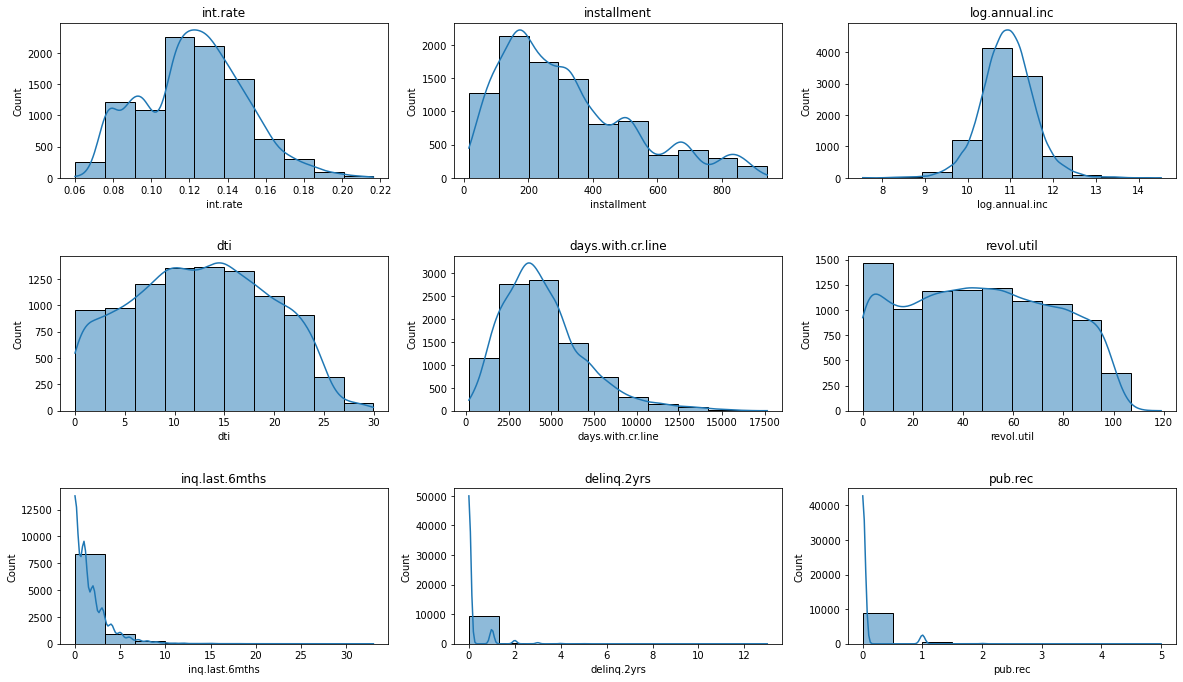

In [15]:
numeric_cols = df.select_dtypes(include=['float']).columns

def _plot_numeric_classes(col, bins=5, kde=True):
    sns.histplot(df[col],
                 bins = bins,
                 kde = kde)

def _distribution_numeric(numeric_cols, row=3, col=3, figsize=(20, 15), bins = 10):

    print('number of numeric field: ', len(numeric_cols)) 
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        break

_distribution_numeric(numeric_cols, row=5, col=3, figsize=(20, 20), bins = 10)

number of category field:  1


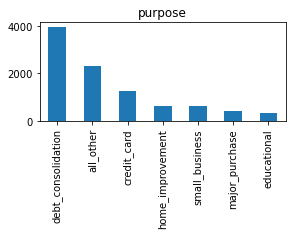

In [16]:
#Đối với biến phân loại
cate_cols = df.select_dtypes(include=['int','object']).columns

def _plot_bar_classes(cate_cols):
  df[cate_cols].value_counts().plot.bar(figsize=(15,10))

def _distribution_cate(cate_cols, row , col , figsize = (20, 15)):

  print('number of category field: ', len(cate_cols)) 

  plt.figure(figsize = figsize) 
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)   
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      _plot_bar_classes(cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

_distribution_cate(cate_cols, row = 4, col = 3, figsize = (20, 15))

<AxesSubplot:xlabel='purpose', ylabel='count'>

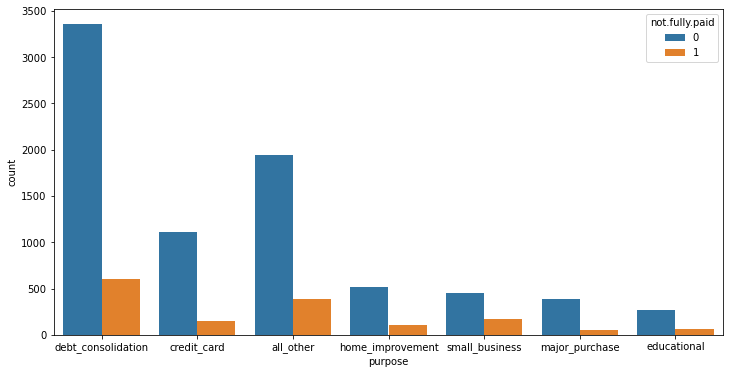

In [17]:
#creating a countplot to see the counts of purpose of loans by not.fully.paid
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='purpose', hue='not.fully.paid')

In the data sample, The purpose of the "debt_consolidation“ & “ all_other” take majority of data. Theses groups also have highest number of not fully paid loan

<AxesSubplot:xlabel='pub.rec', ylabel='count'>

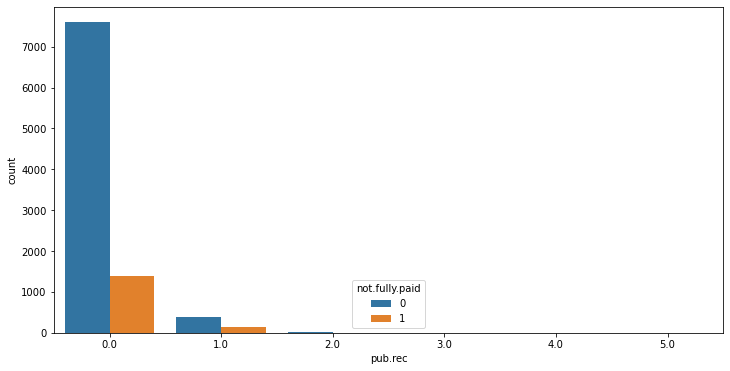

In [18]:
#creating a countplot to see the counts of purpose of loans by not.fully.paid
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='pub.rec', hue='not.fully.paid')

In the data sample, most of the borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments <2 Percentage of borrower with 1 public record turn bad is higher than no pub.rec at 26% and 15% accordingly. 


<AxesSubplot:xlabel='credit.policy', ylabel='count'>

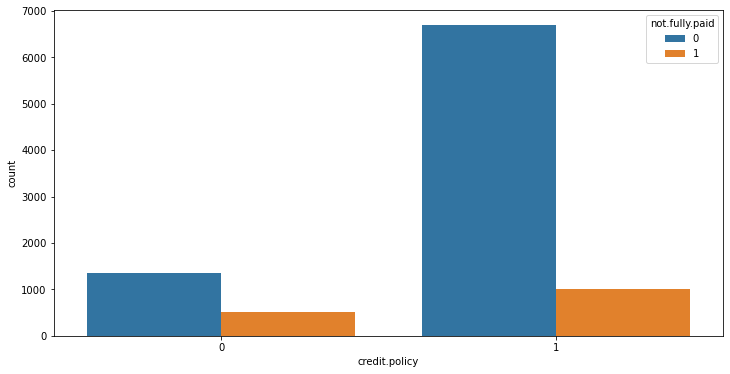

In [19]:
#creating a countplot to see the counts of purpose of loans by not.fully.paid
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='credit.policy', hue='not.fully.paid')

In [20]:
def bar_chart(feature):
    not_fully_paid = df[df['not.fully.paid']==1][feature].value_counts()
    fully_paid = df[df['not.fully.paid']==0][feature].value_counts()
    data = pd.DataFrame([not_fully_paid,fully_paid])
    data.index = ['not_fully_paid','fully_paid']
    data.plot(kind='bar',stacked=True, figsize=(10,5))

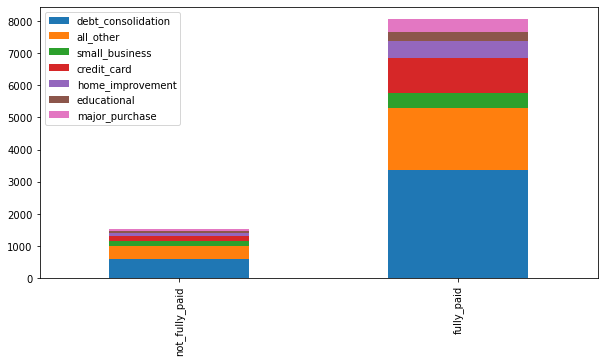

In [21]:
bar_chart('purpose')
# print("fully paid :\n",df[df['not.fully.paid']==1]['purpose'].value_counts())
# print("not fully paid:\n",df[df['not.fully.paid']==0]['purpose'].value_counts())

The purpose loans seem to be a good predictor of the outcome variable since most of loan purchaser with purpose 'debt consolidation' are debtor and not fully paid

number of numeric field:  9


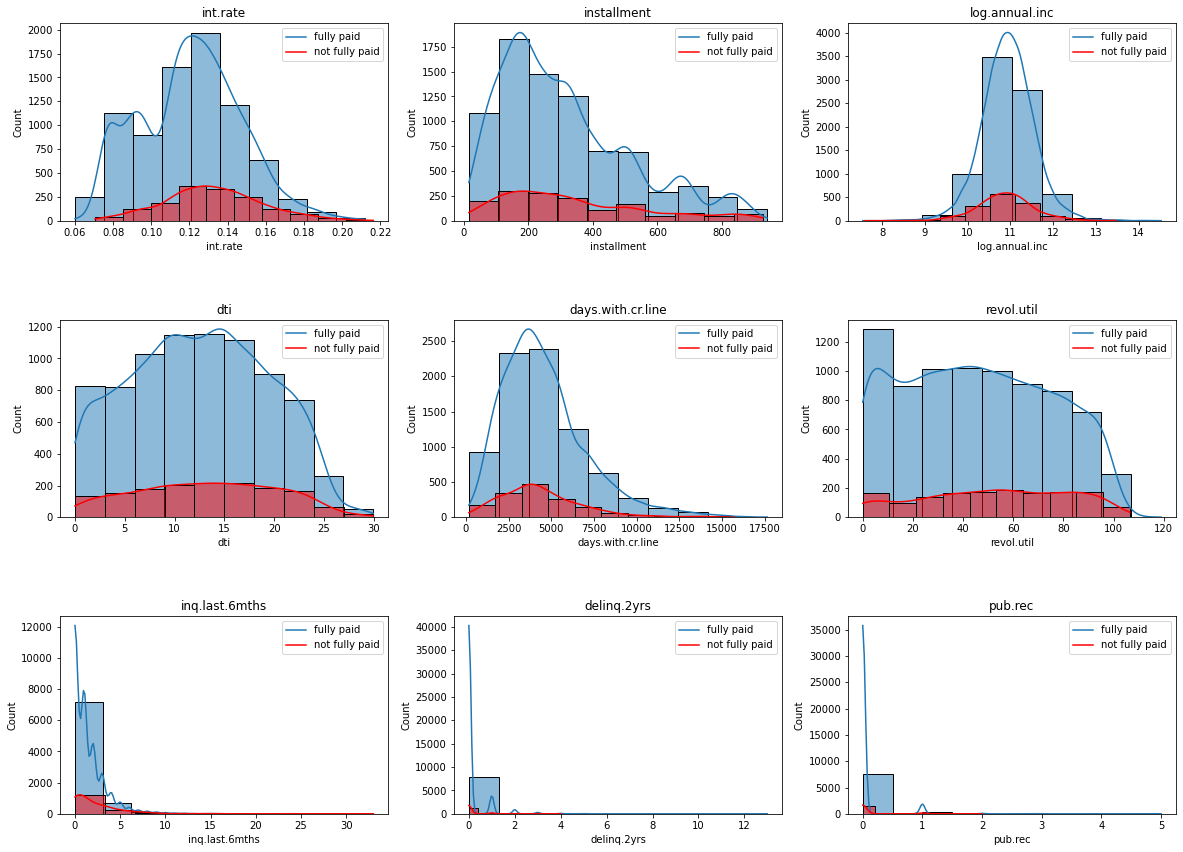

In [22]:
#Biến liên tục vs biến mục tiêu
numeric_cols = df.select_dtypes(include=['float']).columns

def _plot_numeric_classes(col, bins=10, kde=True):
    sns.histplot(df[col][df['not.fully.paid'] == 0],
                 bins = bins,
                 kde = kde)
    sns.histplot(df[col][df['not.fully.paid'] == 1],
                 bins = bins,
                 kde = kde,color='red')
    plt.legend(['fully paid', 'not fully paid'])

def _distribution_numeric(numeric_cols, row=3, col=3, figsize=(20, 15), bins = 10):
    
    print('number of numeric field: ', len(numeric_cols))
    
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        break

_distribution_numeric(numeric_cols, row=4, col=3, figsize=(20, 20), bins = 10)

The data sample does not observe significant outlier. Variables dont’ show good discrimanitory power (% of fully paid is higher than % of not fully paid in all variable's range). Major distribution of sample : 0.1=> 0.16 int.rate, <400 installment, 10-12 log annual income, 10-20 debt to income ratio, 2500 to 5000 days with credit line, <10 revolving utilizalization, < 5 inquiry in last 6 months, 0 public records and <2 deliquency in 2 years

## <font color=red>__3. Feature Engineering & Single Factor Analysis (WOE transformation method)__</font>
<a id='3'></a>



In [5]:
for col_name in df.columns[0:-1]:
    if df[col_name].dtypes == 'object':
        df[col_name].fillna('Missing', inplace=True)
    else:
        df[col_name].fillna(df[col_name].mean(), inplace=True)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


In [24]:
#df.to_excel("loans_treatmissing.xlsx")

In [25]:
gini_raw_result = pd.DataFrame()
def gini_raw(df,variable_name):
    df = df.dropna()
    auc_roc_score = metrics.roc_auc_score(df['not.fully.paid'], df[variable_name])
    gini = 2*auc_roc_score -1
    data = {'Gini raw': [gini], 'Var': variable_name}
    data = pd.DataFrame(data)
    global gini_raw_result
    gini_raw_result = gini_raw_result.append(data, ignore_index = True)
    return gini_raw_result

In [26]:
gini_raw(df,'credit.policy')
gini_raw(df,'int.rate')
gini_raw(df,'installment')
gini_raw(df,'log.annual.inc')
gini_raw(df,'dti')
gini_raw(df,'fico')
gini_raw(df,'days.with.cr.line')
gini_raw(df,'revol.bal')
gini_raw(df,'revol.util')
gini_raw(df,'inq.last.6mths')
gini_raw(df,'delinq.2yrs')
gini_raw(df,'pub.rec')

,Gini raw,Var
0,-0.170870,credit.policy
1,0.240458,int.rate
2,0.063622,installment
3,-0.055707,log.annual.inc
4,0.056528,dti
5,-0.232727,fico
6,-0.039338,days.with.cr.line
7,0.032186,revol.bal
8,0.127712,revol.util
9,0.199197,inq.last.6mths


In [27]:
column_list_1 = ('int.rate', 'installment', 'log.annual.inc','dti','fico','days.with.cr.line','revol.bal','revol.util','delinq.2yrs','inq.last.6mths')
column_list_2 = ('credit.policy','purpose','pub.rec')

In [28]:
def bin_table(data, col_name, n_bins=10):
    df1 = df.loc[:, [col_name, 'not.fully.paid']]
    if col_name in column_list_1:
        bins, threshold = pd.qcut(df1[col_name], q=n_bins, retbins=True, duplicates='drop')
        threshold[0] = -np.inf
        threshold[-1] = np.inf
        bins, threshold = pd.cut(df1[col_name], bins=threshold, retbins=True)
        df1[col_name] = bins
    elif col_name in column_list_2:
        threshold = df1[col_name].unique()
    pivoted = df1.pivot_table(index=col_name, columns='not.fully.paid', aggfunc={'not.fully.paid': 'count'})
    pivoted = pivoted['not.fully.paid'].rename(columns={0: 'GOOD', 1: 'BAD'})
    pivoted.columns.name = None
    pivoted.index.name = col_name
    pivoted['Obs'] = pivoted['GOOD'] + pivoted['BAD']
    pivoted['GOOD/BAD'] = pivoted['GOOD']/pivoted['BAD']
    pivoted['%GOOD'] = pivoted['GOOD']/pivoted['GOOD'].sum()
    pivoted['%BAD'] = pivoted['BAD']/pivoted['BAD'].sum()
    pivoted['WoE'] = np.log(pivoted['%GOOD']/pivoted['%BAD'])
    pivoted['IV'] = (pivoted['%GOOD'] - pivoted['%BAD'])*pivoted['WoE']
    pivoted['COLUMN'] = col_name
    return pivoted, threshold

In [29]:
WoE_features = {}
for col_name in df.columns[0:-1]:
    try:
        summary, threshold = bin_table(df, col_name)
        print('Giá trị IV của cột {} bằng {}'.format(col_name, summary['IV'].sum()))
        WoE_features[col_name] = {
            'summary': summary,
            'threshold': threshold,
            'IV': summary['IV'].sum()
        }
    except Exception as e:
        print(e)
        print(col_name)

Giá trị IV của cột credit.policy bằng 0.15931796327368267
Giá trị IV của cột purpose bằng 0.06809951585017848
Giá trị IV của cột int.rate bằng 0.23776867556583925
Giá trị IV của cột installment bằng 0.023880712673151047
Giá trị IV của cột log.annual.inc bằng 0.02175808688483452
Giá trị IV của cột dti bằng 0.012781950736598357
Giá trị IV của cột fico bằng 0.18507693464291697
Giá trị IV của cột days.with.cr.line bằng 0.01660720448829345
Giá trị IV của cột revol.bal bằng 0.02357695600296702
Giá trị IV của cột revol.util bằng 0.06323056019883044
Giá trị IV của cột inq.last.6mths bằng 0.14843736060655197
Giá trị IV của cột delinq.2yrs bằng 0.00047808877434512393
Giá trị IV của cột pub.rec bằng 0.02591726776728567


In [30]:
df_iv = pd.DataFrame.from_dict(WoE_features, orient='index', columns=['IV'])
df_iv

,IV
credit.policy,0.159318
days.with.cr.line,0.016607
delinq.2yrs,0.000478
dti,0.012782
fico,0.185077
inq.last.6mths,0.148437
installment,0.023881
int.rate,0.237769
log.annual.inc,0.021758
pub.rec,0.025917


In [31]:
def rank_iv(iv):
    if iv < 0.02:
        return 'Not good'
    elif iv < 0.1:
        return 'Weak'
    elif iv < 0.3:
        return 'Medium'
    elif iv < 0.5:
        return 'Strong'
    else:
        return 'Suspicious'
    
df_iv['Rank'] = df_iv['IV'].apply(rank_iv)
df_iv

,IV,Rank
credit.policy,0.159318,Medium
days.with.cr.line,0.016607,Not good
delinq.2yrs,0.000478,Not good
dti,0.012782,Not good
fico,0.185077,Medium
inq.last.6mths,0.148437,Medium
installment,0.023881,Weak
int.rate,0.237769,Medium
log.annual.inc,0.021758,Weak
pub.rec,0.025917,Weak


In [32]:
for col_name in df.columns[0:-1]:
    df[col_name + '_WoE'] = df[col_name].map(WoE_features[col_name]['summary']['WoE'])
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,...,installment_WoE,log.annual.inc_WoE,dti_WoE,fico_WoE,days.with.cr.line_WoE,revol.bal_WoE,revol.util_WoE,inq.last.6mths_WoE,delinq.2yrs_WoE,pub.rec_WoE
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,...,-0.338091,0.103277,-0.145432,0.296385,0.119336,0.050011,-0.090999,0.233144,0.003932,0.039583
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,0.013698,0.109120,-0.000215,-0.104957,0.131481,0.050011,-0.226608,0.233144,0.003932,0.039583
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,-0.062145,-0.032064,0.034028,-0.109142,0.084103,0.184783,0.327588,0.233144,0.003932,0.039583
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,...,0.010379,0.103277,0.087080,0.056334,0.131481,0.050011,-0.093989,0.233144,0.003932,0.039583
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,0.156076,0.103277,0.038287,-0.601520,-0.035807,-0.097779,0.005062,0.233144,0.003932,0.039583


In [33]:
WoE_features['fico']['summary']['WoE']

fico
(-inf, 667.0]    -0.601520
(667.0, 677.0]   -0.276086
(677.0, 687.0]   -0.109142
(687.0, 697.0]   -0.125255
(697.0, 707.0]   -0.104957
(707.0, 717.0]    0.056334
(717.0, 727.0]    0.167035
(727.0, 742.0]    0.296385
(742.0, 767.0]    0.653903
(767.0, inf]      1.033419
Name: WoE, dtype: float64

In [34]:
def _plot(variable_name):
  df_summary = WoE_features[variable_name]['summary']
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WoE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')


Text(0.5, 0.98, 'Visualization WOE trend of all fields')

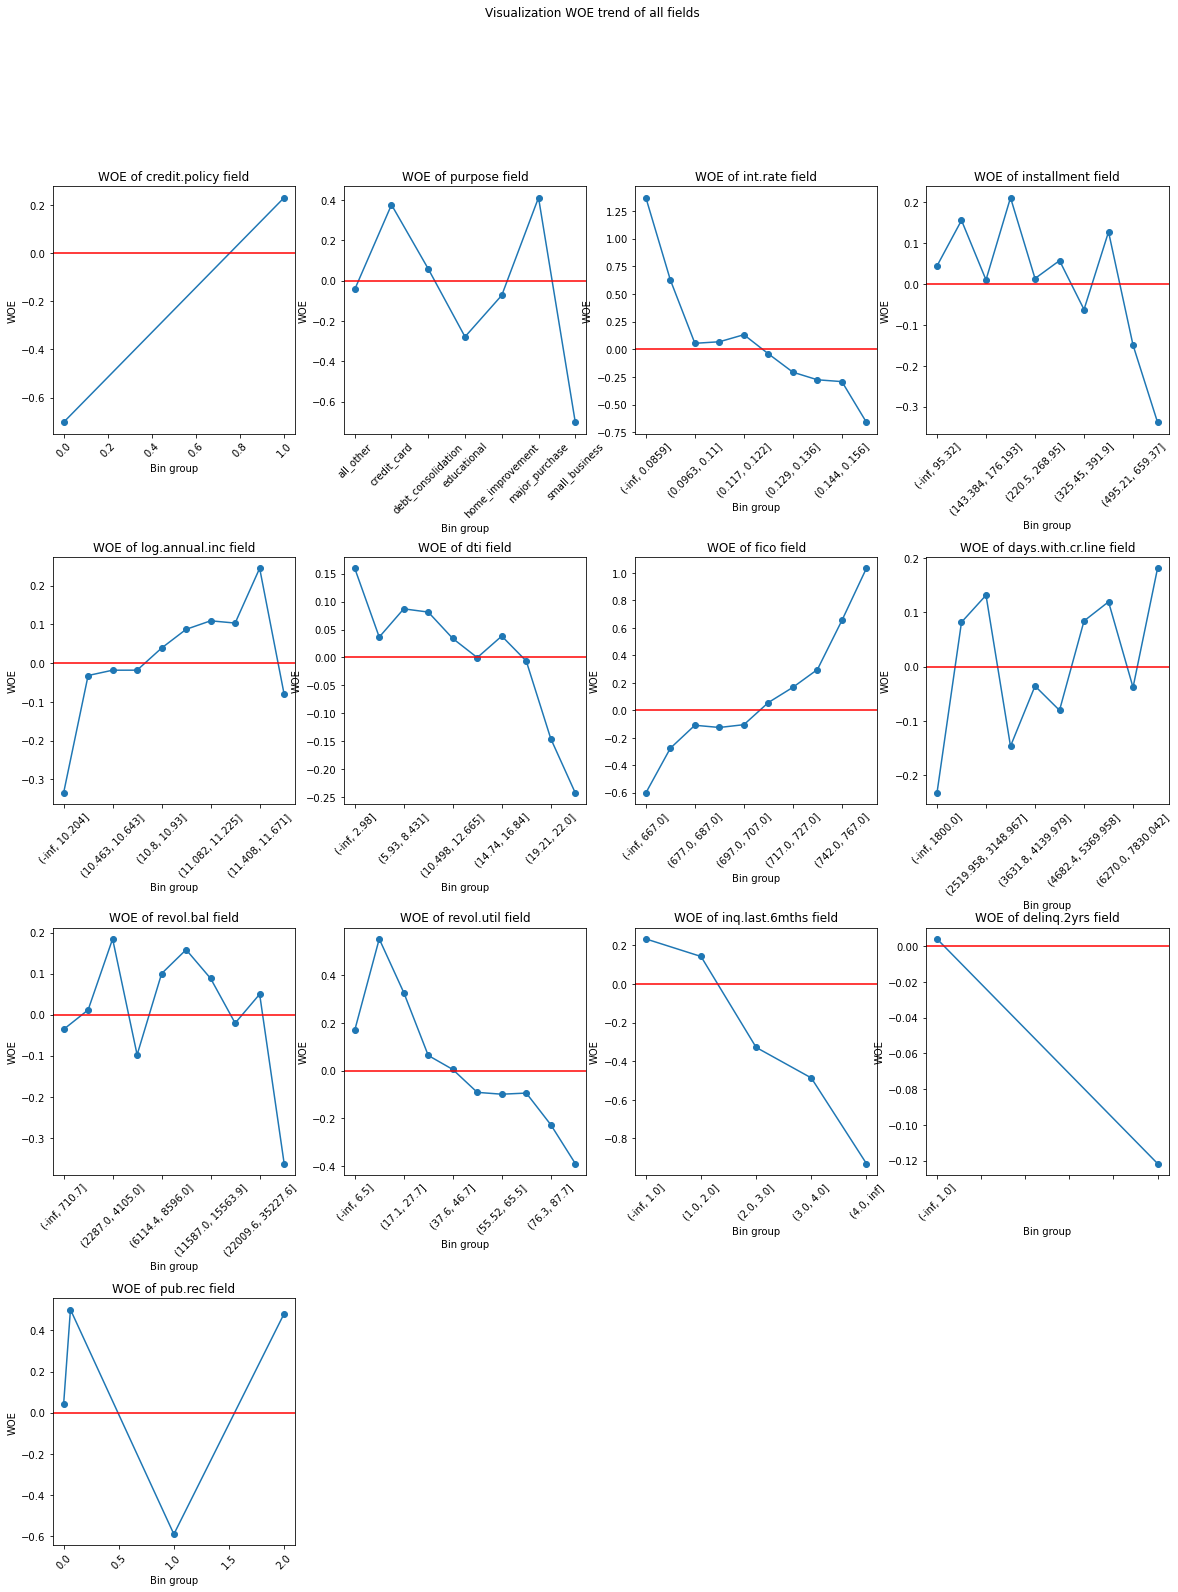

In [35]:
fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i, col_name in enumerate(df.columns[0:13]):
    ax = fig.add_subplot(4, 4, i+1)
    _plot(col_name)
fig.suptitle('Visualization WOE trend of all fields')

Since the option of fine classing: Create 10 bins/groups for a continuous independent variable and then calculates WOE and IV of the variable doesn’t help to adapt to WOE rules: Each category (bin) should have at least 5% of the observations & the WOE should be monotonic, i.e. either growing or decreasing with the groupings => do Coarse classing in excel to follow rules of WOE and brings better result of WOE


In [36]:
# WoE_features['revol.bal']['summary']

In [37]:
gini_order_result = pd.DataFrame()
def gini_order(df,variable_name):
    if col_name in column_list_2:
            df[f'{variable_name}_bkt'] = df[variable_name]
    elif col_name in column_list_1:
            df[f'{variable_name}_bkt'] = pd.qcut(df[variable_name], 10, duplicates = 'drop')
    bad_rate = df.groupby(df[variable_name])['not.fully.paid'].sum()/  df.groupby(f'{variable_name}_bkt')[f'{variable_name}_bkt'].count()
    df[f'{variable_name}_bkt_bad_rate']  = df[variable_name].map(bad_rate)
    AUC_ordered = roc_auc_score(df['not.fully.paid'], df[f'{variable_name}_bkt_bad_rate'], average=None)
    gini_ordered = 2*AUC_ordered - 1
    data = {'Gini order': [gini_ordered], 'Var': variable_name}
    data = pd.DataFrame(data)
    global gini_order_result
    gini_order_result = gini_order_result.append(data, ignore_index = True)
    return gini_order_result


In [38]:
gini_order(df,'credit.policy')
gini_order(df,'purpose')
gini_order(df,'int.rate')
gini_order(df,'installment')
gini_order(df,'log.annual.inc')
gini_order(df,'dti')
gini_order(df,'fico')
gini_order(df,'days.with.cr.line')
gini_order(df,'revol.bal')
gini_order(df,'revol.util')
gini_order(df,'inq.last.6mths')
gini_order(df,'delinq.2yrs')
gini_order(df,'pub.rec')


,Gini order,Var
0,0.170870,credit.policy
1,0.125084,purpose
2,0.368126,int.rate
3,0.908212,installment
4,0.534807,log.annual.inc
5,0.723141,dti
6,0.244132,fico
7,0.684162,days.with.cr.line
8,0.985600,revol.bal
9,0.508430,revol.util


# LOAD DATA AFTER COARSE CLASSING IN EXCEL

MAP WOE after coarse classing in excel ( to make WOE trend monotonic)

In [6]:
#Option 1: mapping WOE value for each variable in excel and load that data to python
df_WOE =pd.read_excel(r'C:\Users\admin\Desktop\Single-Factor-Analysis-sent.xlsx',sheet_name='loans_DropNA')
df_WOE.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,...,pub.rec_score,TotalScore,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,...,31,428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,31,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,31,436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,...,31,456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,31,453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#Option 2, write function to map value

In [41]:
df1 = pd.read_excel(r'C:\Users\admin\Desktop\Single-Factor-Analysis.xlsx',sheet_name='loans_DropNA')
df2 = pd.read_excel(r'C:\Users\admin\Desktop\Single-Factor-Analysis.xlsx',sheet_name='WoE_df', skiprows=1)

numeric = [_ for _ in df2.Variable.unique() if _ not in ('purpose','credit.policy')]

df1.rename(columns = {'log.annual.inc': 'log.annual.income'}, inplace = True)

for var in numeric:
    min_max_interval_df = df2[df2.Variable == var][['Min','Max', 'WoE']]
        
    min_max_interval_df.reset_index(drop = True, inplace = True)
        
    interval_dict = {}
        
    for _ in range(len(min_max_interval_df)):
        interval_dict[(pd.Interval(left = min_max_interval_df.iloc[_]['Min'], 
                                   right = min_max_interval_df.iloc[_]['Max']))] = min_max_interval_df.iloc[_]['WoE'] 
        
    def mapping(x):
        for k, v in interval_dict.items():
            if x in k:
                return v
    
    df1[var + '_WoE'] = df1[var].apply(mapping)
    

In [42]:
a = df2[df2.Variable == 'credit.policy'][['Bucket', 'WoE']].reset_index(drop = True)
b = df2[df2.Variable == 'purpose'][['Bucket', 'WoE']].reset_index(drop = True)

In [43]:
a.set_index('Bucket',inplace=True)
b.set_index('Bucket',inplace=True)

In [44]:
a.to_dict()
b.to_dict()

{'WoE': {'all_other': -0.04160259385091507,
  'credit_card': 0.3795303450578933,
  'debt_consolidation': 0.058075164065396624,
  'educational': -0.29143601672632036,
  'home_improvement': -0.06521983923819029,
  'major_purchase': 0.3967663580612575,
  'small_business': -0.7066238578021506}}

In [45]:
df1['credit.policy' + '_WoE'] = df1['credit.policy'].map(a['WoE'])
df1['purpose' + '_WoE'] = df1['purpose'].map(b['WoE'])
df1.head()

,credit.policy,purpose,int.rate,installment,log.annual.income,dti,fico,days.with.cr.line,revol.bal,revol.util,...,revol.bal_WoE,revol.util_WoE,inq.last.6mths_WoE,delinq.2yrs_WoE,pub.rec_WoE,int.rate_WoE,fico_WoE,days.with.cr.line_WoE,credit.policy_WoE,purpose_WoE
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,...,-0.053940,-0.169164,0.237103,0.003463,0.041414,0.072339,0.168121,0.006458,0.232544,0.058075
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,-0.053940,-0.209418,0.237103,0.003463,0.041414,0.230408,-0.028957,0.024335,0.232544,0.379530
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,0.045412,0.177818,0.237103,0.003463,0.041414,-0.101171,-0.139199,0.006458,0.232544,0.058075
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,...,-0.053940,-0.209418,0.237103,0.003463,0.041414,0.230408,-0.028957,0.024335,0.232544,0.058075
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,0.045412,0.075535,0.237103,0.003463,0.041414,-0.321856,-0.447203,0.006458,0.232544,0.379530


## <font color=red>__4. Split dataset using stratify method__</font>
<a id='4'></a>

Train Model after exclude 2 variables which are not useful :Days.with.cr.line & Delinq.2yrs!

In [7]:
X = df_WOE[['int.rate_WOE',
'inq.last.6mths_WOE',
'credit.policy_WOE',
'purpose_WOE',
'revol.util_WOE',
'pub.rec_WOE',
'installment_WOE',
'fico_WOE','log.annual.inc_WOE','dti_WOE','revol.bal_WOE'
]]
Y = df_WOE["not.fully.paid"]
X.head()

,int.rate_WOE,inq.last.6mths_WOE,credit.policy_WOE,purpose_WOE,revol.util_WOE,pub.rec_WOE,installment_WOE,fico_WOE,log.annual.inc_WOE,dti_WOE,revol.bal_WOE
0,0.068213,0.233144,0.229783,0.058168,-0.167540,0.039573,-0.539465,0.168729,0.074055,-0.079124,-0.051753
1,0.237333,0.233144,0.229783,0.376075,-0.207961,0.039573,0.001618,-0.030995,0.074055,0.020483,-0.051753
2,-0.099415,0.233144,0.229783,0.058168,0.179443,0.039573,0.001618,-0.137928,-0.144022,0.064844,0.043031
3,0.237333,0.233144,0.229783,0.058168,-0.207961,0.039573,0.079289,-0.030995,0.074055,0.064844,-0.051753
4,-0.318050,0.233144,0.229783,0.376075,0.077159,0.039573,0.116914,-0.449431,0.074055,0.020483,0.043031


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify = df_WOE['not.fully.paid'])
X_train.columns

Index(['int.rate_WOE', 'inq.last.6mths_WOE', 'credit.policy_WOE',
       'purpose_WOE', 'revol.util_WOE', 'pub.rec_WOE', 'installment_WOE',
       'fico_WOE', 'log.annual.inc_WOE', 'dti_WOE', 'revol.bal_WOE'],
      dtype='object')

In [49]:
print(y_test.shape)

(1916,)


In [50]:
print(X_test.shape)

(1916, 11)


In [51]:
print(y_train.shape)

(7662,)


## <font color=red>__5. Correlation Test__</font>
<a id='5'></a>



<AxesSubplot:>

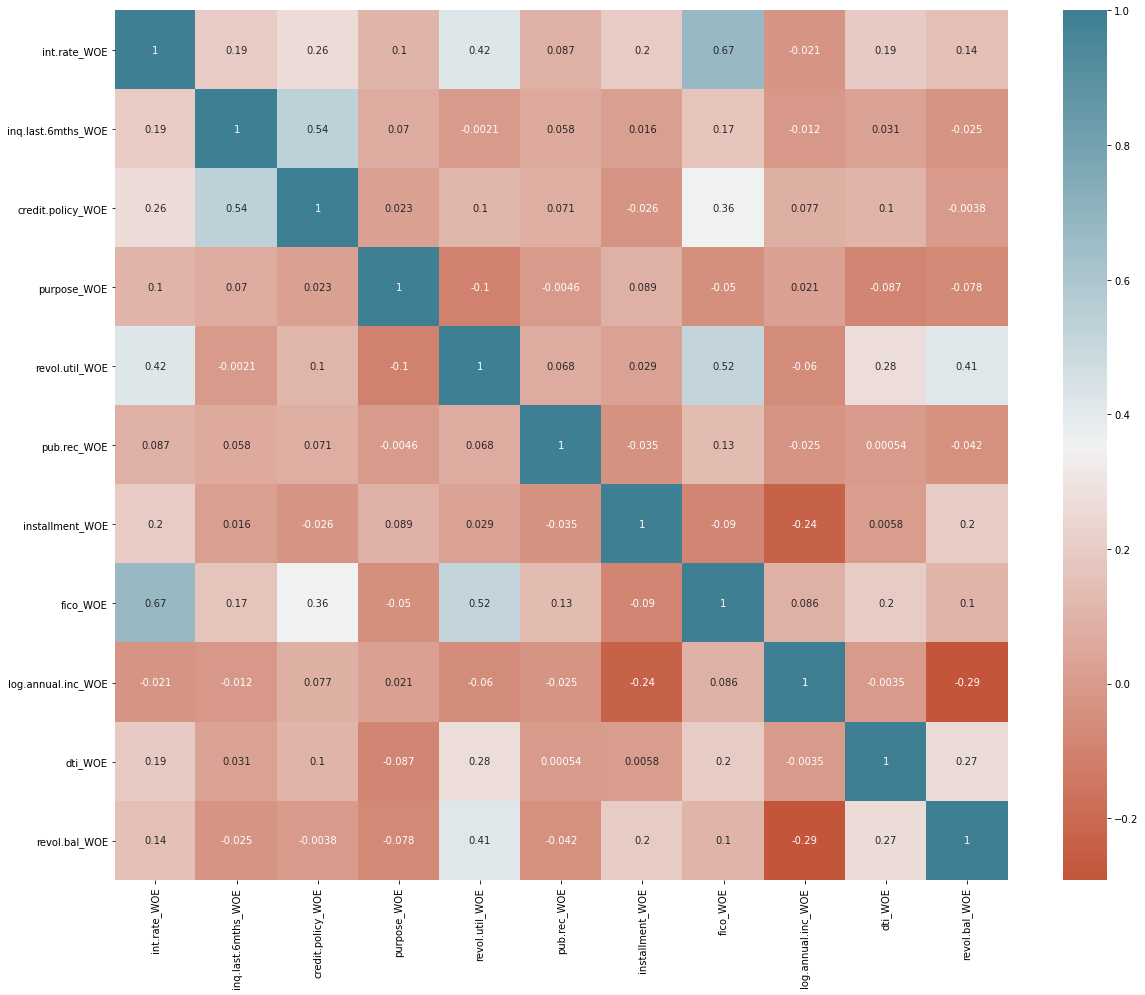

In [47]:
plt.figure(figsize=(20, 16))
correlation = X.corr()
sns.heatmap(X.corr(), annot=True, cmap=sns.diverging_palette(20, 220, n=200))

In [52]:
print(X_train.shape)

(7662, 11)



## <font color=red>__6. Modelling__</font>
<a id='6'></a>


In [53]:
#instantiate model and train
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# make predictions for test set
y_train_predict = logit_model.predict(X_train)
y_pred = logit_model.predict(X_test)
accuracy_train_logit = accuracy_score(y_train, y_train_predict)
accuracy_test_logit = accuracy_score(y_test, y_pred)

y_pred_prob_train = logit_model.predict_proba(X_train)[:, 1]
y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]

auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)

gini_train_logit = 2*auc_roc_score_train - 1
gini_test_logit = 2*auc_roc_score_test - 1
print("Logistic Regression")
print("Gini Train: %.2f%%" % (gini_train_logit  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_logit * 100.0))


Logistic Regression
Gini Train: 35.78%
Gini Test: 39.59%


In [54]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

#instantiate model and train
xgb = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
xgb.fit(X_train, y_train)

# make predictions for test set
y_train_predict = xgb.predict(X_train)
y_pred = xgb.predict(X_test)
accuracy_train_xgb = accuracy_score(y_train, y_train_predict)
accuracy_test_xgb = accuracy_score(y_test, y_pred)

y_pred_prob_train = xgb.predict_proba(X_train)[:, 1]
y_pred_prob_test = xgb.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)
gini_train_xg = 2*auc_roc_score_train - 1
gini_test_xg = 2*auc_roc_score_test - 1

print("XGBoost")
print("Gini Train: %.2f%%" % (gini_train_xg  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_xg * 100.0))
# print("Accuracy Train: %.2f%%" % (accuracy_train_xgb * 100.0))
# print("Accuracy Test: %.2f%%" % (accuracy_test_xgb * 100.0))

[21:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost
Gini Train: 59.75%
Gini Test: 32.51%


In [55]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

Decisiontree = DecisionTreeClassifier().fit(X_train, y_train)
y_train_predict = Decisiontree.predict(X_train)
y_pred = Decisiontree.predict(X_test)
accuracy_train_decision = accuracy_score(y_train, y_train_predict)
accuracy_test_decision = accuracy_score(y_test, y_pred)

y_pred_prob_train = Decisiontree.predict_proba(X_train)[:, 1]
y_pred_prob_test = Decisiontree.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)
gini_train_dt = 2*auc_roc_score_train - 1
gini_test_dt = 2*auc_roc_score_test - 1

print("Decision Tree")
print("Gini Train: %.2f%%" % (gini_train_dt  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_dt * 100.0))

# print("Accuracy Train: %.2f%%" % (accuracy_train_decision * 100.0))
# print("Accuracy Test: %.2f%%" % (accuracy_test_decision * 100.0))

Decision Tree
Gini Train: 99.63%
Gini Test: 3.85%


In [56]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier().fit(X_train, y_train)
y_train_predict = random_forest.predict(X_train)
y_pred = random_forest.predict(X_test)

accuracy_train_forest = accuracy_score(y_train, y_train_predict)
accuracy_test_forest = accuracy_score(y_test, y_pred)


y_pred_prob_train = random_forest.predict_proba(X_train)[:, 1]
y_pred_prob_test = random_forest.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)

gini_train_rd = 2*auc_roc_score_train - 1
gini_test_rd = 2*auc_roc_score_test - 1

print(" RandomForest ")
print("Gini Train: %.2f%%" % (gini_train_rd  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_rd * 100.0))

# print("Accuracy: %.2f%%" % (accuracy_train_forest * 100.0))
# print("Accuracy: %.2f%%" % (accuracy_test_forest * 100.0))

 RandomForest 
Gini Train: 99.44%
Gini Test: 24.10%


In [57]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier().fit(X_train, y_train)
y_train_predict = KNN.predict(X_train)
y_pred = KNN.predict(X_test)

accuracy_train_KNN = accuracy_score(y_train, y_train_predict)
accuracy_test_KNN = accuracy_score(y_test, y_pred)

y_pred_prob_train = KNN.predict_proba(X_train)[:, 1]
y_pred_prob_test = KNN.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)

gini_train_knn = 2*auc_roc_score_train - 1
gini_test_knn = 2*auc_roc_score_test - 1

print(" KNN ")
print("Gini Train: %.2f%%" % (gini_train_knn  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_knn * 100.0))



 KNN 
Gini Train: 68.83%
Gini Test: 12.19%


In [58]:
models = pd.DataFrame({
    'Model': ['XGBoost','Logistic Regression','Decision Tree','RandomForest','KNN'],
       'Score on train': [gini_train_xg, gini_train_logit,gini_train_dt,gini_train_rd, gini_train_knn],
    'Score on test': [gini_test_xg, gini_test_logit,gini_test_dt,gini_test_rd, gini_test_knn]
})
models['% Gini difference'] = (models['Score on train'] - models['Score on test']) * 100.0
models.sort_values(by='Score on test', ascending=False)

,Model,Score on train,Score on test,% Gini difference
1,Logistic Regression,0.357811,0.395912,-3.810106
0,XGBoost,0.597520,0.325065,27.245478
3,RandomForest,0.994365,0.240984,75.338126
4,KNN,0.688298,0.121924,56.637374
2,Decision Tree,0.996251,0.038479,95.777211


Text(0.5, 1.0, 'Scores Metrics Accuracy')

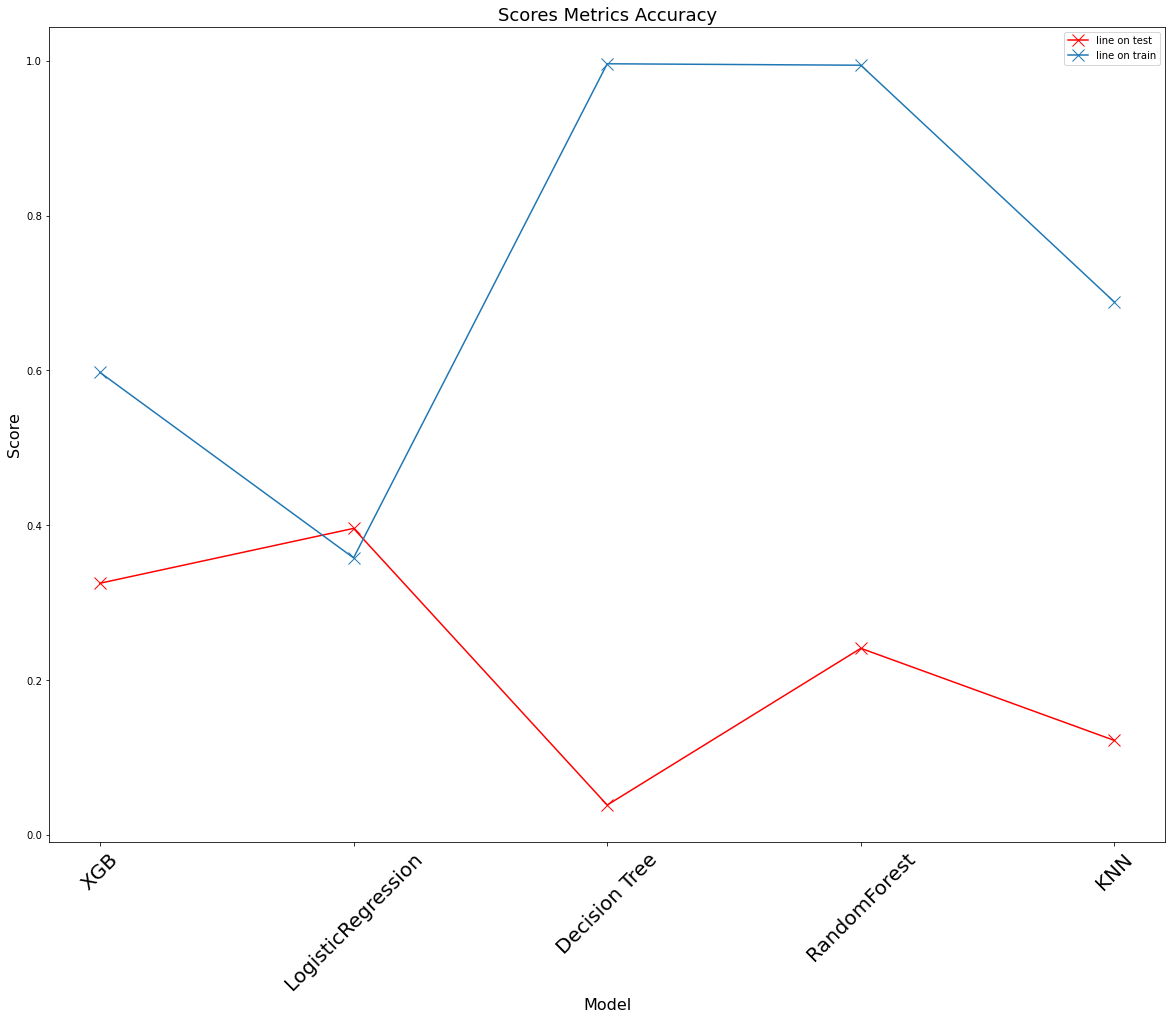

In [59]:
# Visualize accuracy train và validation
plt.figure(figsize=(20, 15))
all_score_train = [gini_train_xg, gini_train_logit,gini_train_dt,gini_train_rd, gini_train_knn]
all_score_val = [gini_test_xg, gini_test_logit,gini_test_dt,gini_test_rd, gini_test_knn]
model_names = ['XGB','LogisticRegression','Decision Tree','RandomForest','KNN']

plt.plot(np.arange(len(all_score_val))+1, all_score_val, marker='x', markersize=12,color='red')
plt.plot(np.arange(len(all_score_train))+1, all_score_train, marker='x', markersize=12)

plt.legend(['line on test', 'line on train'])

plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)

plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=20)
plt.title("Scores Metrics Accuracy", fontsize=18)

## <font color=red>__7. Modelling Evaluation__</font>
<a id='7'></a>

Gini of RandomForestClassifier/Decision Tree are highest, however it's overfitting. LogisticRegression is prefered model(low difference between train and test gini)

In [60]:
def evaluate(model, X_test, y_test):
    # Get the model predictions
    y_pred = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]
    auc_roc_score = metrics.roc_auc_score(y_test, y_pred_prob_test)
    gini = 2*auc_roc_score - 1
    results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test, y_pred)* 100.0],
    "Gini": [gini* 100.0],       
    "Precision" : [metrics.precision_score(y_test, y_pred)* 100.0],
    "Recall" : [metrics.recall_score(y_test, y_pred)* 100.0]})
    # For a more detailed report
    #print(metrics.classification_report(y_test_, prediction_test_))
    return results

In [61]:
evaluate(logit_model, X_test, y_test)

,Accuracy,Gini,Precision,Recall
0,84.08142,39.591224,60.0,1.954397


In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
auc_roc_score = metrics.roc_auc_score(y_test, y_pred_prob_test)
gini = 2*auc_roc_score - 1
print(gini)
print("confusion Matrix is :nn",cm)
# ROC- AUC score
print("ROC-AUC score  test dataset:", roc_auc_score(y_test,y_pred_prob_test))

0.3959122444393608
confusion Matrix is :nn [[1550   59]
 [ 282   25]]
ROC-AUC score  test dataset: 0.6979561222196804


## <font color=red>__7.1 AUC - ROC Curve__</font>
<a id='7.1'></a>

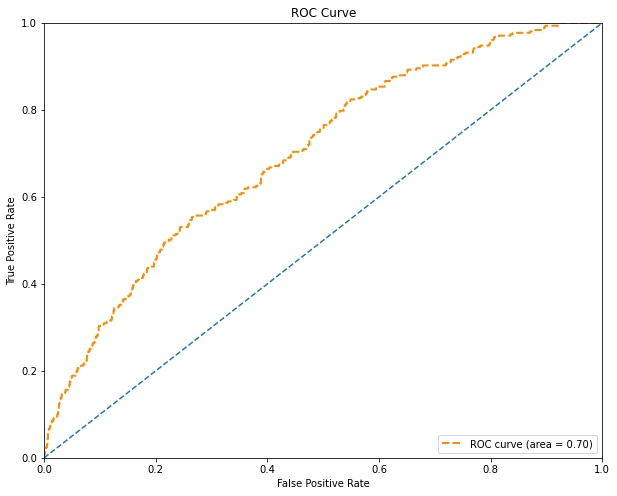

In [63]:
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

In [10]:
#instantiate model and train
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions for test set
y_train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy_train_logit = accuracy_score(y_train, y_train_predict)
accuracy_test_logit = accuracy_score(y_test, y_pred)

y_pred_prob_train = model.predict_proba(X_train)[:, 1]
y_pred_prob_test = model.predict_proba(X_test)[:, 1]

auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)

gini_train_logit = 2*auc_roc_score_train - 1
gini_test_logit = 2*auc_roc_score_test - 1
print("Logistic Regression")
print("Gini Train: %.2f%%" % (gini_train_logit  * 100.0))
print("Gini Test: %.2f%%" % (gini_test_logit * 100.0))

Logistic Regression
Gini Train: 37.04%
Gini Test: 34.64%


# Stratified K-fold validation

In [30]:
from sklearn.model_selection import StratifiedKFold


In [25]:
def plot_roc_curve(fprs, tprs):
    """
    Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates.
    """
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(18,10))
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3,
        label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))
        # Plot the luck line.
        plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label="Random", alpha=.8)
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=4, alpha=.8)
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
    label=r"$\pm$ 1 std. dev.")
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [26]:
def compute_roc_auc(model_, index):
    y_predict = model_.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(Y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

In [27]:
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores = [], [], []

In [28]:
for (train, test), i in zip(cv.split(X, Y), range(5)):
    model.fit(X.iloc[train], Y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(logit_model, train)
    fpr, tpr, auc_score = compute_roc_auc(logit_model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

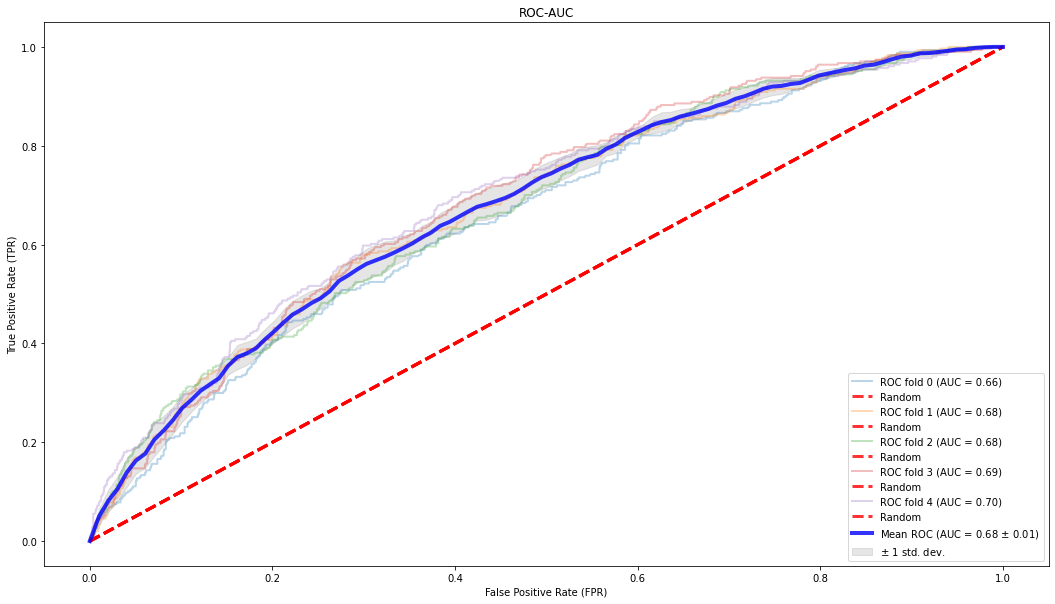

In [29]:
plot_roc_curve(fprs, tprs)
plt.show()

## <font color=red>__7.2 Gini - Cap Curve__</font>
<a id='7.2'></a>

In [64]:
y_test.reset_index(drop = True, inplace = True)

In [65]:
y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
y_pred_prob_test = pd.concat([y_test, pd.DataFrame(y_pred_prob_test)], axis = 1)
y_pred_prob_test.columns = ['y_test', 'y_test_proba']
y_pred_prob_test = y_pred_prob_test.sort_values('y_test_proba')
y_pred_prob_test = y_pred_prob_test.reset_index()
y_pred_prob_test.head()

,index,y_test,y_test_proba
0,1837,0,0.022617
1,1741,0,0.023455
2,1216,0,0.026196
3,1607,0,0.027518
4,1557,0,0.028240


In [66]:
y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
y_pred_prob_test = pd.concat([y_test, pd.DataFrame(y_pred_prob_test)], axis = 1)
y_pred_prob_test.columns = ['y_test', 'y_test_proba']
y_pred_prob_test = y_pred_prob_test.sort_values('y_test_proba')
y_pred_prob_test = y_pred_prob_test.reset_index()
y_pred_prob_test['Cumulative N Population'] = y_pred_prob_test.index + 1
y_pred_prob_test['Cumulative N Good'] = y_pred_prob_test['y_test'].cumsum()
y_pred_prob_test['Cumulative N Bad'] = y_pred_prob_test['Cumulative N Population'] - y_pred_prob_test['y_test'].cumsum()
y_pred_prob_test['Cumulative Perc Population'] = y_pred_prob_test['Cumulative N Population'] / (y_pred_prob_test.shape[0])
y_pred_prob_test['Cumulative Perc Good'] = y_pred_prob_test['Cumulative N Good'] / y_pred_prob_test['y_test'].sum()
y_pred_prob_test['Cumulative Perc Bad'] = y_pred_prob_test['Cumulative N Bad'] / (y_pred_prob_test.shape[0] - y_pred_prob_test['y_test'].sum())
y_pred_prob_test.head()


,index,y_test,y_test_proba,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,1837,0,0.022617,1,0,1,0.000522,0.0,0.000622
1,1741,0,0.023455,2,0,2,0.001044,0.0,0.001243
2,1216,0,0.026196,3,0,3,0.001566,0.0,0.001865
3,1607,0,0.027518,4,0,4,0.002088,0.0,0.002486
4,1557,0,0.028240,5,0,5,0.002610,0.0,0.003108


Text(0.5, 1.0, 'Gini')

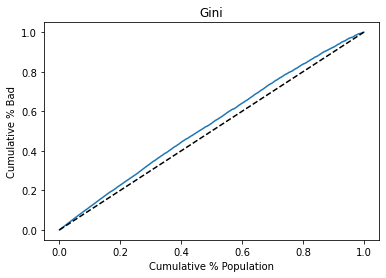

In [67]:
# Plot Gini (CAP CURVE)
plt.plot(y_pred_prob_test['Cumulative Perc Population'], y_pred_prob_test['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(y_pred_prob_test['Cumulative Perc Population'], y_pred_prob_test['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

## <font color=red>__7.3 KS __</font>
<a id='7.3'></a>

In [68]:
KS = max(y_pred_prob_test['Cumulative Perc Bad'] - y_pred_prob_test['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.2903780242649754

In [69]:
y_pred_prob = logit_model.predict_proba(X_test)[:, 1]

In [70]:
def _KM(y_pred, n_bins):
  _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
  cmd_BAD = []
  cmd_GOOD = []
  BAD_id = set(np.where(y_test == 0)[0])
  GOOD_id = set(np.where(y_test == 1)[0])
  total_BAD = len(BAD_id)
  total_GOOD = len(GOOD_id)
  for thres in thresholds:
    pred_id = set(np.where(y_pred <= thres)[0])
    # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
    cmd_BAD.append(per_BAD)
    # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
    per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
    cmd_GOOD.append(per_GOOD)
  cmd_BAD = np.array(cmd_BAD)
  cmd_GOOD = np.array(cmd_GOOD)
  return cmd_BAD, cmd_GOOD, thresholds

cmd_BAD, cmd_GOOD, thresholds = _KM(y_pred_prob, n_bins=20)

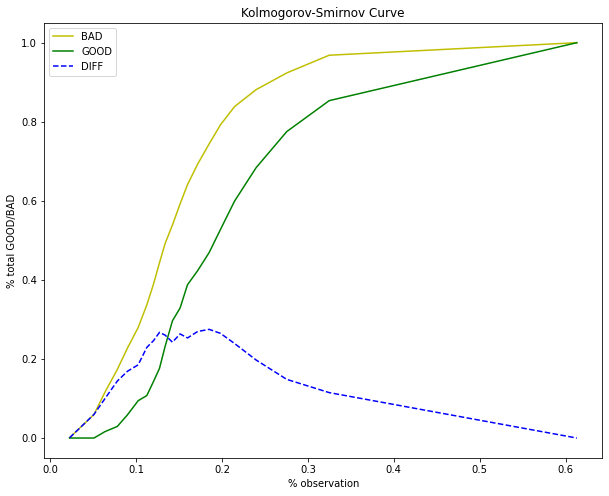

In [71]:
def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
  plt.figure(figsize = (10, 8))
  plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
  plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
  plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
  plt.xlabel('% observation')
  plt.ylabel('% total GOOD/BAD')
  plt.title('Kolmogorov-Smirnov Curve')
  plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

## <font color=red>__8 Understand the model __</font>
<a id='8'></a>

In [72]:
betas_dict = dict(zip(list(X.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
alpha

-1.6535144704087588

In [73]:
coefficient = pd.DataFrame(list(betas_dict.items()),columns = ['Variable','Coef'])
coefficient.reset_index(drop=True, inplace=True)
coefficient

,Variable,Coef
0,int.rate_WOE,-0.374230
1,inq.last.6mths_WOE,-0.534306
2,credit.policy_WOE,-0.311327
3,purpose_WOE,-0.898996
4,revol.util_WOE,-0.179919
5,pub.rec_WOE,-0.658721
6,installment_WOE,-0.893538
7,fico_WOE,-0.499486
8,log.annual.inc_WOE,-1.045968
9,dti_WOE,-0.084058


In [74]:
#Feature Importance

Feature: 0, Score: -0.37423
Feature: 1, Score: -0.53431
Feature: 2, Score: -0.31133
Feature: 3, Score: -0.89900
Feature: 4, Score: -0.17992
Feature: 5, Score: -0.65872
Feature: 6, Score: -0.89354
Feature: 7, Score: -0.49949
Feature: 8, Score: -1.04597
Feature: 9, Score: -0.08406
Feature: 10, Score: -0.56645


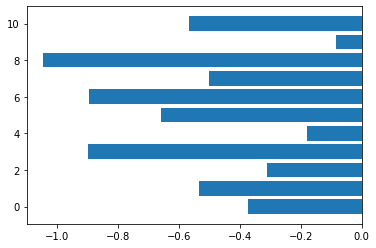

In [75]:
importance = logit_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.barh([x for x in range(len(importance))], importance)
pyplot.show()

## <font color=red>__9 Test oversample & other transformation method __</font>
<a id='9'></a>
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

Random over-sampling:
1    8045
0    8045
Name: not.fully.paid, dtype: int64


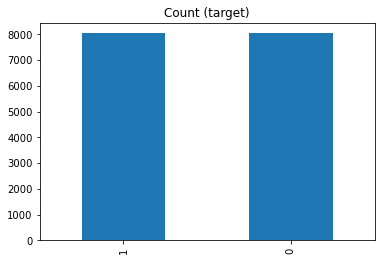

In [76]:
# Class count
count_class_0, count_class_1 = df["not.fully.paid"].value_counts()

# Divide by class
df_class_0 = df[df["not.fully.paid"] == 0]
df_class_1 = df[df["not.fully.paid"] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over["not.fully.paid"].value_counts())

df_test_over["not.fully.paid"].value_counts().plot(kind='bar', title='Count (target)');


In [77]:
#df_test_over.to_excel("df_test_over.xlsx")
df_test_over = pd.read_excel(r'C:\Users\Admin\Downloads\df_test_over.xlsx',sheet_name='Sheet1')
df_test_over

,Unnamed: 0,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,...,revol.bal_bkt,revol.bal_bkt_bad_rate,revol.util_bkt,revol.util_bkt_bad_rate,inq.last.6mths_bkt,inq.last.6mths_bkt_bad_rate,delinq.2yrs_bkt,delinq.2yrs_bkt_bad_rate,pub.rec_bkt,pub.rec_bkt_bad_rate
0,0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,...,28854,0.0,52.1,0.272727,0.0,0.117501,0.0,0.158188,0.0,0.154804
1,1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,...,33623,0.0,76.7,0.100000,0.0,0.117501,0.0,0.158188,0.0,0.154804
2,2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,...,3511,0.0,25.6,0.111111,1.0,0.151281,0.0,0.158188,0.0,0.154804
3,3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,...,33667,0.0,73.2,0.272727,1.0,0.151281,0.0,0.158188,0.0,0.154804
4,4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,...,4740,0.0,39.5,0.200000,0.0,0.117501,1.0,0.175121,0.0,0.154804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16085,9121,0,debt_consolidation,0.1347,135.70,10.858999,16.71,677,5070.000000,11346,...,11346,1.0,72.7,0.166667,5.0,0.278388,0.0,0.158188,0.0,0.154804
16086,4874,1,debt_consolidation,0.1183,497.01,11.054429,15.87,732,8460.000000,26127,...,26127,1.0,44.8,0.071429,1.0,0.151281,0.0,0.158188,0.0,0.154804
16087,8472,0,debt_consolidation,0.1324,38.04,10.524064,16.81,652,3900.000000,1097,...,1097,0.5,58.1,0.111111,6.0,0.335404,0.0,0.158188,1.0,0.256121
16088,8113,0,credit_card,0.1204,232.64,11.050890,14.55,672,4290.000000,7180,...,7180,1.0,34.4,0.266667,4.0,0.236674,0.0,0.158188,0.0,0.154804


In [78]:
X_over = df_test_over[['int.rate_WoE',
'inq.last.6mths_WoE',
'credit.policy_WoE',
'purpose_WoE',
'revol.util_WoE',
'pub.rec_WoE',
'installment_WoE',
'fico_WoE','log.annual.inc_WoE','dti_WoE','revol.bal_WoE'
]]
Y_over = df_test_over["not.fully.paid"]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [80]:
#instantiate model and train
logit_model_test = LogisticRegression()
logit_model_test.fit(X_train, y_train)
logit_model_test.fit(X_train, y_train) # Xây dựng mô hình

# make predictions for test set
y_train_predict = logit_model_test.predict(X_train)
y_pred = logit_model_test.predict(X_test)
accuracy_train_logit = accuracy_score(y_train, y_train_predict)
accuracy_test_logit = accuracy_score(y_test, y_pred)

y_pred_prob_train = logit_model_test.predict_proba(X_train)[:, 1]
y_pred_prob_test = logit_model_test.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)
gini_train = 2*auc_roc_score_train - 1
gini_test = 2*auc_roc_score_test - 1
print("Logistic Regression with over sampling method")
print("Gini Train: %.2f%%" % (gini_train  * 100.0))
print("Gini Test: %.2f%%" % (gini_test * 100.0))
print("Accuracy Train: %.2f%%" % (accuracy_train_logit  * 100.0))
print("Accuracy Test: %.2f%%" % (accuracy_test_logit * 100.0))

Logistic Regression with over sampling method
Gini Train: 37.96%
Gini Test: 31.33%
Accuracy Train: 83.89%
Accuracy Test: 83.92%


In [81]:
#SAVE MODEL FINAL
import pickle
pickle.dump(logit_model, open('pd_model.sav', 'wb'))

# LOGISTIC REGRESSION WITH OTHER MISSING VALUE TREATMENT AND TRANSFORMATION METHOD

In [26]:
import pandas as pd

df = pd.read_excel(r'C:\Users\admin\Desktop\loans.xlsx',sheet_name='Data')

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [89]:
from pprint import pprint

In [28]:
# Chia train/test theo tỷ lệ 80:20.
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['not.fully.paid'])
X_train = df_train.copy()
y_train = X_train.pop("not.fully.paid")

X_test = df_test.copy()
y_test = X_test.pop("not.fully.paid")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7662, 13) (7662,)
(1916, 13) (1916,)


In [29]:
# Lấy list names của các biến phân loại và biến liên tục.
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [30]:
# Pipeline xử lý cho biến phân loại
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lý missing data bằng cách thay thế most frequent
        ('onehot', OneHotEncoder()), # Biến đổi giá trị của biến phân loại thành véc tơ OneHot
    ]
)

In [31]:
# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
           ('scaler', MinMaxScaler()) # Xử lý missing data bằng MinMax scaler
    ]
)

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names), # áp dụng pipeline cho biến liên tục
        ('cat', cat_pl, cat_names), # áp dụng pipeline cho biến phân loại
    ]
)

In [33]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("classifier", LogisticRegression(penalty='l2', C=0.5, max_iter=200, class_weight=[0.3, 0.7]))
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 0.84
Accuracy on test: 0.84


In [34]:
y_pred_prob_train = completed_pl.predict_proba(X_train)[:, 1]
y_pred_prob_test = completed_pl.predict_proba(X_test)[:, 1]
auc_roc_score_train = metrics.roc_auc_score(y_train, y_pred_prob_train)
auc_roc_score_test = metrics.roc_auc_score(y_test, y_pred_prob_test)
gini_train = 2*auc_roc_score_train - 1
gini_test = 2*auc_roc_score_test - 1

In [35]:
print("Logistic Regression with other transformation method")
print("Gini Train: %.2f%%" % (gini_train  * 100.0))
print("Gini Test: %.2f%%" % (gini_test * 100.0))


Logistic Regression with other transformation method
Gini Train: 33.82%
Gini Test: 31.72%


other method does not help us increase gini of the model 

## <font color=red>__10 Scorecard __</font>
<a id='10'></a>

In [82]:
import numpy as np

def _CreditScore(beta, alpha, woe, n = 11, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

In [83]:
betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'int.rate_WOE': -0.3742295212314303,
 'inq.last.6mths_WOE': -0.5343056686677622,
 'credit.policy_WOE': -0.3113272887869882,
 'purpose_WOE': -0.8989960927225911,
 'revol.util_WOE': -0.1799188169946613,
 'pub.rec_WOE': -0.6587212953276584,
 'installment_WOE': -0.8935380684209359,
 'fico_WOE': -0.49948558644084873,
 'log.annual.inc_WOE': -1.0459684645804623,
 'dti_WOE': -0.08405769630156398,
 'revol.bal_WOE': -0.5664545767028795}

In [84]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in X_train.columns:
  test = df2[['Bucket', 'WoE']]
  test.reset_index(drop = True)
  test.set_index('Bucket',inplace=True)
  for feature, woe in test.iterrows():
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)    
      # Add woe
      woe = float(woe.values[0])
      woes.append(woe)
      # Add beta
      col_woe = col
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 12)
      scores.append(score)

df_WOE_python = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE_python.head()

,Columns,Features,WOE,Betas,Scores
0,int.rate_WOE,"(0, 130]",0.119296,-0.37423,54.826705
1,int.rate_WOE,"(130, 210]",0.080433,-0.37423,53.777603
2,int.rate_WOE,"(210, 310]",0.002275,-0.37423,51.667736
3,int.rate_WOE,"(310, 570]",0.002219,-0.37423,51.666213
4,int.rate_WOE,"(570, 760]",-0.056183,-0.37423,50.089656


In [85]:
#tổng điểm bộ test

In [86]:
test_case = X_test.iloc[5, 1:13]
test_case.index

Index(['inq.last.6mths_WOE', 'credit.policy_WOE', 'purpose_WOE',
       'revol.util_WOE', 'pub.rec_WOE', 'installment_WOE', 'fico_WOE',
       'log.annual.inc_WOE', 'dti_WOE', 'revol.bal_WOE'],
      dtype='object')

In [87]:
def search_score(obs, col):
     feature = [str(inter) for inter in list(df_WOE_python['Features'].unique())][0]
     score = df_WOE_python[(df_WOE_python['Columns'] == col) & (df_WOE_python['Features'] == feature)]['Scores'].values[0]
     return score

In [88]:
search_score(test_case, 'purpose_WOE')

59.34251595331072

In [90]:
def total_score(obs):
    scores = dict()
    for col in obs.index:
        scores[col] = search_score(obs, col)
        total_score = sum(scores.values())
    return scores, total_score

scores, total_score = total_score(test_case)
print('score for each fields: \n')
pprint(scores)
print('\n')
print('final total score: ', total_score)

score for each fields: 

{'credit.policy_WOE': 54.28540807461195,
 'dti_WOE': 52.32966899326259,
 'fico_WOE': 55.90457996724172,
 'inq.last.6mths_WOE': 56.204219680950196,
 'installment_WOE': 59.29554763116535,
 'log.annual.inc_WOE': 60.607267688805145,
 'pub.rec_WOE': 57.27486226330505,
 'purpose_WOE': 59.34251595331072,
 'revol.bal_WOE': 56.48087295066122,
 'revol.util_WOE': 53.15458946797793}


final total score:  564.8795326712919
